In [1]:
import sys
sys.path.append("../")

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

from datasets.llff import LLFFDataset
from datasets.llff import *

In [4]:
from datasets.colmap_utils import \
    read_cameras_binary, read_images_binary, read_points3d_binary

In [5]:
root_dir = "/scratch/saksham/data/freiburg_small/"

In [6]:
camdata = read_cameras_binary(os.path.join(root_dir, 'sparse/0/cameras.bin'))
img_wh = (80,  60)
H = camdata[1].height
W = camdata[1].width
focal = camdata[1].params[0] * img_wh[0]/W

In [7]:
imdata = read_images_binary(os.path.join(root_dir, 'sparse/0/images.bin'))

In [8]:
perm = np.argsort([imdata[k].name for k in imdata])

In [23]:
w2c_mats = []
bottom = np.array([0, 0, 0, 1.]).reshape(1, 4)
for k in imdata:
    im = imdata[k]
    R = im.qvec2rotmat()
    t = im.tvec.reshape(3, 1)
    w2c_mats += [np.concatenate([np.concatenate([R, t], 1), bottom], 0)]
w2c_mats = np.stack(w2c_mats, 0)
poses = np.linalg.inv(w2c_mats) # (N_images, 4, 4) cam2world matrices

In [24]:
poses = torch.from_numpy(poses).float()
from gradslam.geometry.geometryutils import relative_transformation
poses = relative_transformation(
            poses[0].unsqueeze(0).repeat(poses.shape[0], 1, 1), poses, orthogonal_rotations = True
        )
poses = poses.numpy().astype('float64')
poses.shape

(101, 4, 4)

In [25]:
scale_factor = 2

In [26]:
poses2 = poses.copy()

In [27]:
poses2[:,:-1,-1] = poses2[:,:-1,-1]/scale_factor 

In [28]:
poses[10,:-1,-1], poses2[10,:-1,-1]

(array([-0.12218475,  0.54374218, -0.18802428]),
 array([-0.06109238,  0.27187109, -0.09401214]))

In [29]:
poses_colmap = poses
poses_tum = poses2

In [30]:
import numpy as np
from scipy.spatial.transform import Rotation as R
import utils.transformations as tf

In [31]:
poses_colmap = poses
poses_tum = poses2

In [32]:
q_colmap = np.array([R.from_matrix(poses_colmap[i, :3,:3]).as_quat() for i in range(len(poses_colmap))])
q_tum = np.array([R.from_matrix(poses_tum[i, :3,:3]).as_quat() for i in range(len(poses_tum))])

In [33]:
t_colmap = poses_colmap[:,:-1,-1]
t_tum = poses_tum[:,:-1,-1]

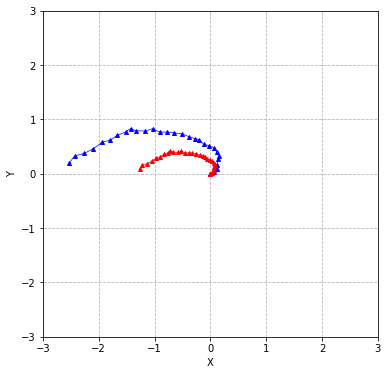

In [34]:
%matplotlib inline
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt

fr_id = 29
fig = plt.figure(figsize=(6, 6))
ax0 = plt.subplot(111)
ax0.set_xlim((-3, 3))            
ax0.set_ylim((-3, 3))
ax0.set_xlabel('X')
ax0.set_ylabel('Y')
ax0.grid(ls='--', color='0.7')

tvec_col = t_colmap
tvec_tum = t_tum

title = ax0.set_title('')
traj_line_col, = ax0.plot([], [], c='blue', ls='-', marker='^', linewidth=0.7, markersize=4)
traj_line_tum, = ax0.plot([], [], c='red', ls='-', marker='^', linewidth=0.7, markersize=4)
traj_line_col.set_data(tvec_col[:fr_id + 1,0], tvec_col[:fr_id + 1, 1])
traj_line_tum.set_data(tvec_tum[:fr_id + 1,0], tvec_tum[:fr_id + 1, 1])

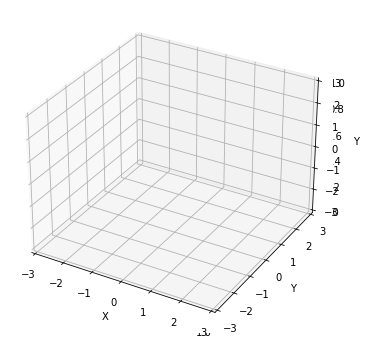

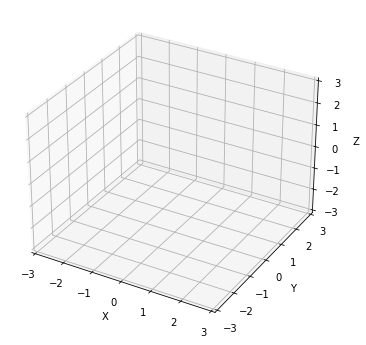

In [35]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from utils.threed_plotter import draw_trajectory_3D

fig1 = plt.figure(figsize=(6, 6))
fig1.add_subplot(111, projection='3d')
ax1 = fig1.add_subplot(111, projection='3d')
ax1.set_xlim3d((-3, 3))            
ax1.set_ylim3d((-3, 3))
ax1.set_zlim3d((-3, 3))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Y')
ax1.grid(ls='--', color='0.7')

fig2 = plt.figure(figsize=(6, 6))
ax2 = fig2.add_subplot(111, projection='3d')
ax2.set_xlim3d((-3, 3))            
ax2.set_ylim3d((-3, 3))
ax2.set_zlim3d((-3, 3))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.grid(ls='--', color='0.7')

In [36]:
def drawframe(fr_id):
    """
    :param fr_id: frame id
    :param poses: (N_img, 3) camera positions
    """
    
    ax1.clear()
    
    ax1.set_xlim3d((-3, 3))            
    ax1.set_ylim3d((-3, 3))
    ax1.set_zlim3d((-3, 3))
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.grid(ls='--', color='0.7')
    
    verts_colmap = draw_trajectory_3D(q_colmap[fr_id], t_colmap[fr_id], ax1, ax2)
    verts_tum = draw_trajectory_3D(q_tum[fr_id], t_tum[fr_id], ax1, ax2)

    ax1.add_collection3d(Poly3DCollection(verts_colmap, facecolors='blue',
                                            linewidths=1, edgecolors='blue', alpha=.25))
    ax1.add_collection3d(Poly3DCollection(verts_tum, facecolors='red',
                                            linewidths=1, edgecolors='red', alpha=.25))
    
        
    return

anim = animation.FuncAnimation(fig1, drawframe, frames=30, interval=100)

plt.close(anim._fig)
HTML(anim.to_html5_video())

INFO - 2021-06-05 17:02:20,671 - animation - Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO - 2021-06-05 17:02:20,675 - animation - MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x432 -pix_fmt rgba -r 10.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkj0lbben/temp.m4v
